In [69]:
# Import libs, functions, classes for calculation and type hinting.
import gc
from pathlib import Path
from pickle import load

from category_encoders import CountEncoder
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import numpy as np
from numpy.typing import NDArray
import optuna
from pandas import DataFrame, Index, read_excel, Series
import seaborn as sns
import shap
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod.generalized_linear_model import GLMResultsWrapper
from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import Booster, DMatrix, train

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

optuna.logging.set_verbosity(0)

In [2]:
def read_eqa_data() -> DataFrame:
    SUP_DATA_FILES: list[str] = ['./Extended Data 2.xlsx',
                                 'Supplementary Table 1', 'Supplementary Table 2']
    COLS: list[list[str]] = [['panel ID', 'recall', 'precision', 'RMSLE'],
                             ['panel ID', 'Exonic Size', 'Gene Count', 'DNA shearing', 'UMI',
                              'Reads Length', 'Sequencing Depth', 'Sequencing Platform',
                              'Reference Genome', 'Callers', 'somatic VAF cut-off', 'TMB VAF cut-off',
                              'Involved Variants', 'Filter Rules', 'Germline Strategy']]

    # prepare the basic data.

    panel_df: DataFrame = (read_excel(SUP_DATA_FILES[0], sheet_name=SUP_DATA_FILES[1],
                                      skiprows=[0, 1], usecols='A,B,C,F',
                                      index_col=None, header=None,
                                      names=COLS[0])
                           .merge(right=read_excel(SUP_DATA_FILES[0],
                                                   sheet_name=SUP_DATA_FILES[2],
                                                   skiprows=[0, 1], usecols='A:C,G:H,J:S',
                                                   index_col=None, header=None,
                                                   names=COLS[1]),
                                  on='panel ID', how='left', validate='1:1')
                           .reset_index(drop=True)
                           )
    return panel_df


def load_list_from_pickle_file(pkf) -> list:
    with open(pkf, 'rb') as _f:
        _ls = load(_f)
    return _ls


def read_simulated_data() -> DataFrame:
    SUP_DATA_FILES: list[str] = ['./Extended Data 2.xlsx',
                                 'Supplementary Table 2']
    sup_table2: DataFrame = read_excel(SUP_DATA_FILES[0], sheet_name=SUP_DATA_FILES[1],
                                       skiprows=[0, 1], usecols='A,C',
                                       index_col=None, header=None,
                                       names=['panel ID', 'Gene Count'])
    panel_gene_count: dict = dict(zip(sup_table2['panel ID'].values,
                                      sup_table2['Gene Count'].values))

    all_panel_results = []
    RESULT_DIR: str = '/hot_warm_data/zhangyuanfeng/TMB_2/Article/Result/allin1/per_lab'
    COLUMN_LIST: list[str] = ['panel ID', 'Method', 'Exonic Size', 'recall', 'precision',
                              'Involved: Nonsense', 'Involved: Nonstop',
                              'Involved: Synonymous', 'Involved: Slient',
                              'Involved: Splice site', 'Involved: Translation Start Site',
                              'Filter: Hotspot', 'TMB VAF cut-off', 'coef', 'intercept',
                              'whfh', 'wlfl', 'whfl', 'wlfh', 'R2', 'RMSLE',
                              'Concordance Correlation Coefficient', 'Discrete Accuracy']

    for _pkl in [_f.as_posix() for _f in Path(RESULT_DIR).rglob('panel*.pkl')]:
        with open(_pkl, 'rb') as _pkf:
            all_panel_results.extend([_r for _r in load(_pkf) if _r])
    pooled_df: DataFrame = DataFrame(all_panel_results,
                                     columns=COLUMN_LIST)
    pooled_df['Gene Count'] = pooled_df['panel ID'].map(panel_gene_count)

    return pooled_df

In [3]:
def pre_process_data(df: DataFrame, remove_prefix: bool) -> DataFrame:
    columns_list: Index[str] = df.columns
    to_drop_columns: list[str] = []

    # Add method column
    if remove_prefix:
        df['Method'] = (df['panel ID'].str.replace('[abcdep]', '',
                                                    regex=True)
                        .astype('int'))
    else:
        df['Method'] = df['panel ID'].apply(lambda x: x[:-1] if x[-1] in ['a', 'b', 'c', 'd', 'e'] else x)

    # Convert panel id column
    # if 'panel ID' in columns_list:
    #     df['panel ID'] = (df['panel ID'].str.replace('[abcdep]', '',
    #                                                  regex=True)
    #                       .astype('int'))

    # Convert gene count to avoid multi-collinearity.
    if 'Exonic Size' in columns_list and 'Gene Count' in columns_list:
        df['Gene Count per Mb'] = df['Gene Count'] / df['Exonic Size']
        to_drop_columns.append('Gene Count')

    # Merge recall and precision.
    if 'recall' in columns_list and 'precision' in columns_list:
        df['rgbrp'] = abs(1 / df['recall'] - 1 / df['precision'])

    # Convert DNA shearing column.
    if 'DNA shearing' in columns_list:
        _count_encoder = CountEncoder(cols='DNA shearing')
        _count_encoder.fit(df['DNA shearing'])
        _df_encoded: DataFrame = _count_encoder.transform(df['DNA shearing'])
        df['DNA shearing'] = _df_encoded['DNA shearing']

    # Convert the UMI column
    if 'UMI' in columns_list:
        df['UMI'] = df['UMI'].apply(lambda x: False if x == 'No' else True)

    # Convert Reads Length column
    if 'Reads Length' in columns_list:
        df['Reads Length / 50'] = df['Reads Length'] / 50
        to_drop_columns.append('Reads Length')

    # Convert the Sequencing Depth column
    if 'Sequencing Depth' in columns_list:
        df['Sequencing Depth / 100'] = df['Sequencing Depth'] / 100
        to_drop_columns.append('Sequencing Depth')

    # Convert the Sequencing Platform column
    # Use target coding as the one-hot-coding would bring severe multicollinearity.
    if 'Sequencing Platform' in columns_list:
        # _PLATFORM_POOLING_DICT: dict[str, str] = {
        #     'Illumina NovaSeq 6000': 'Illumina NovaSeq 6000',
        #     'MGISEQ-2000': 'MGISEQ-2000',
        #     'Illumina NextSeq 500': 'Illumina NextSeq 500/550',
        #     'Gene+Seq 2000': 'MGISEQ-2000',
        #     'Illumina NextSeq 550Dx': 'Illumina NextSeq 500/550',
        #     'Illumina NextSeq 550': 'Illumina NextSeq 500/550',
        #     'MGI DNBSEQ-T7': 'MGI DNBSEQ-T7',
        #     'MGI DNBSEQ-T7RS': 'MGI DNBSEQ-T7',
        #     'Illumina NextSeq 2000': 'Illumina NextSeq 2000',
        #     'Illumina NextSeq CN500': 'Illumina NextSeq 500/550',
        #     'Illumina HiSeq X10': 'Illumina HiSeq X10',
        #     'Genetron S2000': 'MGISEQ-2000',
        #     'MGISEQ-2000RS': 'MGISEQ-2000'
        # }
        # df['Sequencing Platform'] = df['Sequencing Platform'].map(_PLATFORM_POOLING_DICT)
        # df = get_dummies(data=df, columns=['Sequencing Platform'], prefix_sep=': ')
        _target: str
        if 'rgbrp' in df.columns:
            _target = 'rgbrp'
        else:
            if 'RMSLE' in df.columns:
                _target = 'RMSLE'
            else:
                raise ValueError('No target variable found!')
        _avaliable_platforms = df['Sequencing Platform'].unique()
        _target_coding_dict: dict = {}
        _median_target: Series = (df[['Sequencing Platform', _target]]
                          .groupby(by='Sequencing Platform')
                          [_target]
                          .median())
        df['Sequencing Platform'] = df['Sequencing Platform'].map(lambda x: _median_target[x])

    # Convert the Reference Genome column.
    # One-hot coding would bring severe multicollinearity.
    # Consider coding this column by the feature of the FASTA files.
    # hs37d5 = b37 + decoy + fixed some bugs
    # b37 = hg19 + fixed some bugs
    # hg19 contains the old mit sequence. 
    # hg19 ≈ GRCh37.
    # humanG1Kv37 ≈ b37.
    if 'Reference Genome' in columns_list:
        # _GENOME_POOLING_DICT: dict[str, str] = {
        #     'hg19': 'hg19/GRCh37',
        #     'GRCh37': 'hg19/GRCh37',
        #     'hs37d5': 'hs37d5',
        #     'b37': 'b37/humanG1Kv37',
        #     'humanG1Kv37': 'b37/humanG1Kv37'
        # }
        _GENOME_POOLING_DICT: dict[str, int] = {
            'hg19': 0,
            'GRCh37': 0,
            'hs37d5': 2,
            'b37': 1,
            'humanG1Kv37': 1
        }
        df['Reference Genome'] = df['Reference Genome'].map(_GENOME_POOLING_DICT)
        # df = get_dummies(data=df, columns=['Reference Genome'], prefix_sep=': ')
        

    # Convert the Callers column.
    """
    {
        'Delly',
        'Freebayes',
        'GATK HaplotypeCaller',
        'GATK Mutect2',
        'Lofreq',
        'Manta',
        'Provided by Manufacturer',
        'Samtools',
        'TNscope',
        'VarDict',
        'VarScan2',
        'VariDict',
        'other',
        'self-developed'}
    """
    if 'Callers' in columns_list:
        _CALLER_DICT: dict[str, str] = {
            'Delly': 'Caller: Delly',
            'Freebayes': 'Caller: Freebayes',
            'GATK HaplotypeCaller': 'Caller: HaplotypeCaller',
            'GATK Mutect2': 'Caller: Mutect2',
            'Lofreq': 'Caller: Lofreq',
            'Manta': 'Caller: Manta',
            'Provided by Manufacturer': 'Caller: OEM',
            'Samtools': 'Caller: Samtools',
            'TNscope': 'Caller: TNscope',
            'VarDict': 'Caller: VarDict',
            'VarScan2': 'Caller: VarScan2',
            'VariDict': 'Caller: VariDict',
            'other': 'Caller: other',
            'self-developed': 'Caller: in lab'}
        for _c, _l in _CALLER_DICT.items():
            df[_l] = df['Callers'].map(lambda x: _c in x)
        to_drop_columns.append('Callers')

    # Convert the VAF cut-off columns.
    for _vaf_col in ['somatic VAF cut-off', 'TMB VAF cut-off']:
        if _vaf_col in columns_list:
            _VAF_DICT: dict[float, float] = {
                .01: .0, .015: .5, 0.02: 1.0,
                .025: 1.5, .03: 2.0, 0.05: 4.0, 0.1: 9.0}
            df[_vaf_col] = df[_vaf_col].map(_VAF_DICT)

    # Convert the Involved Variants column.
    if 'Involved Variants' in columns_list:
        _TYPE_DICT: dict[str, str] = {
            'Other': 'Involved: Other',
            'Missense': 'Involved: Missense',
            'Nonstop': 'Involved: Nonstop',
            'Indel': 'Involved: Indel',
            'Splicing Site': 'Involved: Splicing Site',
            'Synonymous': 'Involved: Synonymous',
            'Nonsense': 'Involved: Nonsense'}
        for _t, _l in _TYPE_DICT.items():
            df[_l] = df['Involved Variants'].map(lambda x: _t in x)
        to_drop_columns.append('Involved Variants')

    # Convert the Filter Rules column
    if 'Filter Rules' in columns_list:
        _FILTER_DICT: dict[str, str] = {
            'Other': 'Filter: Other',
            'SNP': 'Filter: SNP',
            'Driver': 'Filter: Driver',
            'Known': 'Filter: Known',
            'Hotspot': 'Filter: Hotspot'}
        for _f, _l in _FILTER_DICT.items():
            df[_l] = df['Filter Rules'].map(lambda x: _f in x)
        to_drop_columns.append('Filter Rules')

    # Convert the Germline Strategy column
    if 'Germline Strategy' in columns_list:
        _ST_DICT: dict[str, bool] = {
            'tumor-normal': True, 'tumor-only': False
        }
        df['Germline Strategy'] = df['Germline Strategy'].map(_ST_DICT)

    if to_drop_columns:
        df = df.drop(columns=to_drop_columns).copy(deep=True)

    return df

#### Simulated Analysis
1. Load and preprocess.
2. Check the collinearity among features
3. Build models.
   + Generalized Linear Model (statsmodels lib)
   + XGBoost (xgboost lib)
4. Explain the importance of techinical parameters as factors

In [4]:
# load and preprocess the simulated data
simulated_data = (pre_process_data(df=read_simulated_data(), remove_prefix=True)
                  [['rgbrp', 'Exonic Size', 'Gene Count per Mb',
                   'Involved: Nonsense', 'Involved: Nonstop', 'Involved: Synonymous',
                   'Involved: Slient', 'Involved: Splice site',
                   'Involved: Translation Start Site', 'Filter: Hotspot',
                   'TMB VAF cut-off', 'R2', 'RMSLE', 'Discrete Accuracy']])
simulated_data.head(n=5)

,rgbrp,Exonic Size,Gene Count per Mb,Involved: Nonsense,Involved: Nonstop,Involved: Synonymous,Involved: Slient,Involved: Splice site,Involved: Translation Start Site,Filter: Hotspot,TMB VAF cut-off,R2,RMSLE,Discrete Accuracy
0,0.0,1.547179,416.887768,True,False,False,False,False,False,True,0.0,0.938145,0.474624,0.945389
1,0.0,1.547179,416.887768,True,False,False,False,False,False,True,1.0,0.938150,0.474578,0.945387
2,0.0,1.547179,416.887768,True,False,False,False,False,False,True,2.0,0.938268,0.474351,0.945394
3,0.0,1.547179,416.887768,True,False,False,False,False,False,True,4.0,0.939711,0.473670,0.941029
4,0.0,1.547179,416.887768,True,False,False,False,False,False,True,9.0,0.926548,0.440047,0.935549


In [5]:
# # Check the relationship among features.
# ### Draw the corrplot to see the 1:1 relationship.
simulated_features: DataFrame = simulated_data.drop(columns=['R2', 'RMSLE', 'Discrete Accuracy'])
simulated_corr: DataFrame = (simulated_features).corr()
mask: NDArray = np.triu(np.ones_like(simulated_corr, dtype=bool))
fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(simulated_corr, mask=mask,
            cmap='vlag', annot=False, square=True,
            linewidths=.5, cbar_kws={"shrink": .5})  # type: ignore
plt.title('Corrplot of features of the simulated experiment.')

In [6]:
# ### Calculate the Variance Inflation Factor.
_simulated_numeric: DataFrame = simulated_features.copy(deep=True)
for _col in ['Involved: Nonsense', 'Involved: Nonstop', 'Involved: Synonymous',
             'Involved: Slient', 'Involved: Splice site', 'Involved: Translation Start Site',
             'Filter: Hotspot']:
    _simulated_numeric[_col] = _simulated_numeric[_col].apply(lambda x: 1 if x else 0)
simulated_vif_df = DataFrame()
simulated_vif_df['Features'] = simulated_features.columns.to_list()
simulated_vif_df['VIF'] = [variance_inflation_factor(_simulated_numeric.values, i) for i in range(_simulated_numeric.shape[1])]
simulated_vif_df

In [7]:
# # remove all variables that won't be used later to save memory.
# del ax, fig, mask, simulated_corr, simulated_vif_df

In [8]:
# Build model
## prepare dataset
target_variables: list[str] = ['R2', 'RMSLE', 'Discrete Accuracy']
fixed_effects_features: list[str] = [
    'Exonic Size', 'Gene Count per Mb', 'rgbrp',
    'TMB VAF cut-off', 'Involved: Nonsense', 'Involved: Nonstop',
    'Involved: Synonymous', 'Involved: Slient', 'Involved: Splice site',
    'Involved: Translation Start Site', 'Filter: Hotspot']
fixed_effects: str = (
    ' ~ Q("Exonic Size") + Q("Gene Count per Mb") + rgbrp + ' +
    'Q("TMB VAF cut-off") + Q("Involved: Nonsense") + ' +
    'Q("Involved: Nonstop") + Q("Involved: Synonymous") + ' +
    'Q("Involved: Slient") + Q("Involved: Splice site") + ' +
    'Q("Involved: Translation Start Site") + Q("Filter: Hotspot")')

simulated_for_lr: DataFrame = simulated_data.copy(deep=True)
for _col in ['Involved: Nonsense', 'Involved: Nonstop', 'Involved: Synonymous',
             'Involved: Slient', 'Involved: Splice site', 'Involved: Translation Start Site',
             'Filter: Hotspot']:
    simulated_for_lr[_col] = simulated_for_lr[_col].apply(lambda x: 1 if x else 0)

(r2_x_train,
 r2_x_test,
 r2_y_train,
 r2_y_test) = train_test_split(
     simulated_for_lr[fixed_effects_features], simulated_for_lr['R2'],
     test_size=0.2, random_state=41)
(rmsle_x_train,
 rmsle_x_test,
 rmsle_y_train,
 rmsle_y_test) = train_test_split(
     simulated_for_lr[fixed_effects_features], simulated_for_lr['RMSLE'],
     test_size=0.2, random_state=41)
(acc_x_train,
 acc_x_test,
 acc_y_train,
 acc_y_test) = train_test_split(
     simulated_for_lr[fixed_effects_features], simulated_for_lr['Discrete Accuracy'],
     test_size=0.2, random_state=41)

In [9]:
# ## smf.glm to see the summary
# r2_glm: GLMResultsWrapper = (smf.glm(data=simulated_data[fixed_effects_features + ['R2']],
#                                      formula=f'R2{fixed_effects}',
#                                      family=sm.families.Gaussian())
#                                 .fit())
# rmsle_glm: GLMResultsWrapper = (smf.glm(data=simulated_data[fixed_effects_features + ['RMSLE']],
#                                         formula=f'RMSLE{fixed_effects}',
#                                         family=sm.families.Gaussian())
#                                  .fit())
# acc_glm: GLMResultsWrapper = (smf.glm(data=simulated_data[fixed_effects_features + ['Discrete Accuracy']],
#                                             formula=f'Q("Discrete Accuracy"){fixed_effects}',
#                                             family=sm.families.Gaussian())
#                                  .fit())

# ## sklearn.LinearRegression for sklearn.inspection.permutation_importance and shap.LinearExplainer
# r2_lr: LinearRegression = LinearRegression().fit(X=r2_x_train, y=r2_y_train)
# rmsle_lr: LinearRegression = LinearRegression().fit(X=rmsle_x_train, y=rmsle_y_train)
# acc_lr: LinearRegression = LinearRegression().fit(X=acc_x_train, y=acc_y_train)

In [10]:
## xgboost and tuning
### prepare data, define tuning function and param_grid.
param_grid: dict = {'max_depth': [1, 2, 3, 4, 5, 6],
                    'learning_rate': [0.1, 0.2, 0.5, 0.6, 0.7, 0.8, 0.9],
                    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
                    'gamma': [0.01, 0.1, 1, 10],
                    'min_child_weight': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                    'tree_method': ['gpu_hist'],
                    'gpu_id': [0]}  # Use GPU accelerated algorithm

def xgbt_trial_obj(trial: optuna.Trial, 
                   x_train_validate: DataFrame, y_train_validate: DataFrame,
                   x_test: DataFrame, y_test: DataFrame):
    params: dict = {'tree_method': 'gpu_hist', 'gpu_id': 0,
                    'eta': trial.suggest_uniform(name='eta', low=0.1, high=0.9),
                    'max_depth': trial.suggest_int(name='max_depth', low=4, high=7),
                    'subsample': trial.suggest_float(name='subsample', low=0.5, high=1.0),
                    'gamma': trial.suggest_loguniform(name='gamma', low=1e-2, high=10),
                    'min_child_weight': trial.suggest_int(name='min_child_weight', low=1, high=10),
                    'lambda': trial.suggest_float('lambda', 0.1, 1.0),
                    'alpha': trial.suggest_float('alpha', 0.0, 10.0)}
    (_x_train,
     _x_validate,
     _y_train,
     _y_validate) = train_test_split(x_train_validate, y_train_validate,
                                     test_size=0.2, random_state=41)
    _d_train = DMatrix(_x_train, label=_y_train)
    _d_validate = DMatrix(_x_validate, label=_y_validate)
    _d_test = DMatrix(x_test, label=y_test)
    _xgbt_model: Booster = train(params, _d_train,
                                 evals=[(_d_validate, 'validation')],
                                 num_boost_round=100000,
                                 early_stopping_rounds=200,
                                 callbacks=[optuna.integration
                                                 .XGBoostPruningCallback(trial=trial,
                                                                         observation_key='validation-rmse')])
    _y_pred = _xgbt_model.predict(_d_test)
    rmse = mean_squared_error(y_test, _y_pred, squared=False)
    return rmse

In [11]:
%%capture
### tuning for acc
r2_study = optuna.create_study(direction='minimize')
r2_study.optimize(func=lambda trial: xgbt_trial_obj(trial,  # type: ignore
                                                    r2_x_train,
                                                    r2_y_train,
                                                    r2_x_test,
                                                    r2_y_test),
                  n_trials=1000,
                  n_jobs=80,
                  show_progress_bar=True)
gc.collect()

### tuning for acc
rmsle_study = optuna.create_study(direction='minimize')
rmsle_study.optimize(func=lambda trial: xgbt_trial_obj(trial,  # type: ignore
                                                    rmsle_x_train,
                                                    rmsle_y_train,
                                                    rmsle_x_test,
                                                    rmsle_y_test),
                     n_trials=1000,
                     n_jobs=80,
                     show_progress_bar=True)
gc.collect()

### tuning for acc
acc_study = optuna.create_study(direction='minimize')
acc_study.optimize(func=lambda trial: xgbt_trial_obj(trial,  # type: ignore
                                                    acc_x_train,
                                                    acc_y_train,
                                                    acc_x_test,
                                                    acc_y_test),
                   n_trials=1000,
                   n_jobs=80,
                   show_progress_bar=True)
gc.collect()

In [ ]:
print('r2:')
print(f'Best parameters: {r2_study.best_params}')
print(f'Best RMSE: {r2_study.best_value}')
print('=' * 50)
print('rmsle:')
print(f'Best rparameters: {rmsle_study.best_params}')
print(f'Best RMSE: {rmsle_study.best_value}')
print('=' * 50)
print('acc:')
print(f'Best rparameters: {acc_study.best_params}')
print(f'Best RMSE: {acc_study.best_value}')

In [14]:
## build xgboost model using best params.
def best_xgbt_model(optimized_params: dict,
                    x_train: DataFrame, y_train: DataFrame,
                    x_test: DataFrame, y_test: DataFrame):
    _xgbt: Booster = train(params=optimized_params,
                           dtrain=DMatrix(x_train, label=y_train),
                            num_boost_round=500,
                            maximize=False)
    rmse = mean_squared_error(y_true=y_test,
                              y_pred=_xgbt.predict(data=DMatrix(x_test, label=y_test)),
                              squared=False)

    return  [_xgbt, rmse]


### r2
# r2_best_params: dict = {'eta': 0.147762689341973,
#                         'max_depth': 7,
#                         'subsample': 0.7622044189731699,
#                         'gamma': 0.02686720238508999,
#                         'min_child_weight': 6,
#                         'lambda': 0.6764501257307061,
#                         'alpha': 4.669735775297603}
r2_xgbt, r2_rmse = best_xgbt_model(optimized_params=r2_study.best_params,  # type: ignore
                                   x_train=r2_x_train, y_train=r2_y_train,
                                   x_test=r2_x_test, y_test=r2_y_test)
print(f'r2 xgbt: rmse on test part = {r2_rmse}')

### rmsle
# rmsle_best_params: dict = {'eta': 0.15393993372867165,
#                            'max_depth': 7,
#                            'subsample': 0.556731067978623,
#                            'gamma': 0.012264167543377644,
#                            'min_child_weight': 5, 'lambda': 0.31165034117635954,
#                            'alpha': 9.805464573766203}
rmsle_xgbt, rmsle_rmse = best_xgbt_model(optimized_params=rmsle_study.best_params,  # type: ignore
                                         x_train=rmsle_x_train, y_train=rmsle_y_train,
                                         x_test=rmsle_x_test, y_test=rmsle_y_test)
print(f'rmsle xgbt: rmse on test part = {rmsle_rmse}')

### acc
# acc_best_params: dict = {'eta': 0.6219491492711096,
#                          'max_depth': 7,
#                          'subsample': 0.7919362670897964,
#                          'gamma': 0.014260764079869967,
#                          'min_child_weight': 10,
#                          'lambda': 0.17000446240125744,
#                          'alpha': 1.1390791357880616}
acc_xgbt, acc_rmse = best_xgbt_model(optimized_params=acc_study.best_params,  # type: ignore
                                     x_train=acc_x_train, y_train=acc_y_train,
                                     x_test=acc_x_test, y_test=acc_y_test)
print(f'acc xgbt: rmse on test part = {acc_rmse}')

r2 xgbt: rmse on test part = 0.002944701114331954
rmsle xgbt: rmse on test part = 0.04775540599070659
acc xgbt: rmse on test part = 0.010544552330722197


In [34]:
# Explain the importance of features (technical parameters)
import shap

## r2
r2_xgbt.set_param({'predictor': 'gpu_predictor'})
r2_dtest = DMatrix(r2_x_test, label=r2_y_test)
r2_pred = r2_xgbt.predict(r2_dtest, output_margin=True)
r2_exp = shap.TreeExplainer(r2_xgbt)
r2_shap_obj = r2_exp(r2_dtest)
r2_shap_interaction_values = r2_exp.shap_interaction_values(r2_x_test)
r2_shap_values = r2_shap_obj.values
np.abs(r2_shap_values.sum(axis=1) + r2_shap_obj.base_values - r2_pred).max()

1.3113022e-06

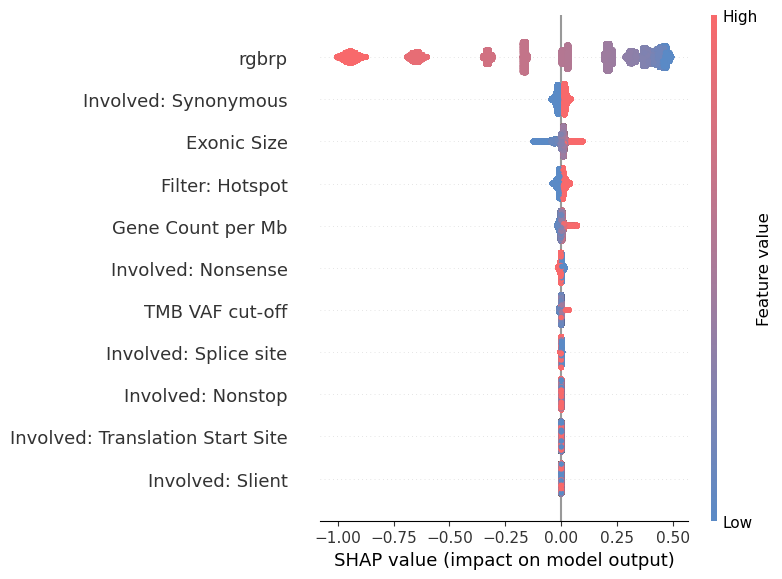

In [51]:
shap.summary_plot(r2_shap_values,
                  r2_x_test,
                  cmap = mc.LinearSegmentedColormap.from_list("",
                                                              ['#5a8ac6',
                                                               '#f8696b']))

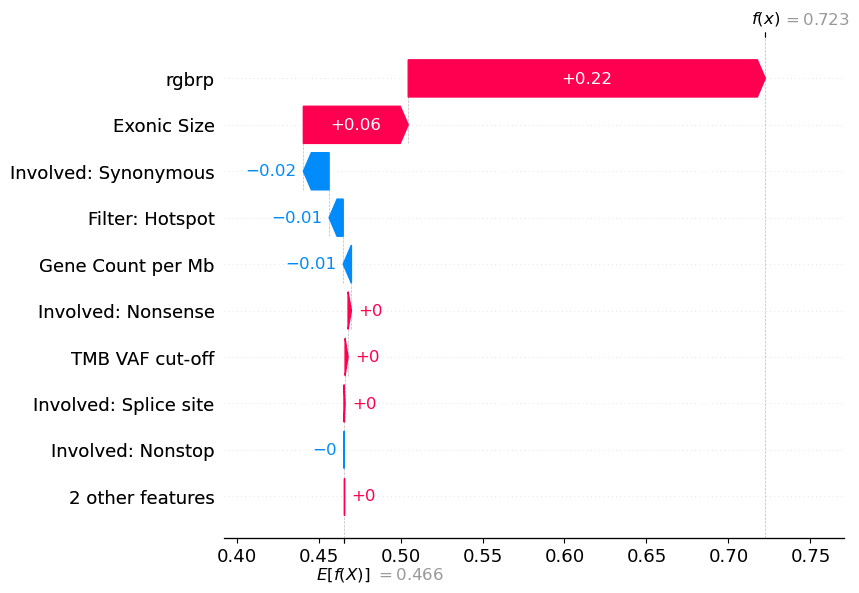

In [52]:
shap.plots._waterfall.waterfall_legacy(r2_exp.expected_value,
                                       r2_shap_values[0],
                                       feature_names=r2_x_test.columns)

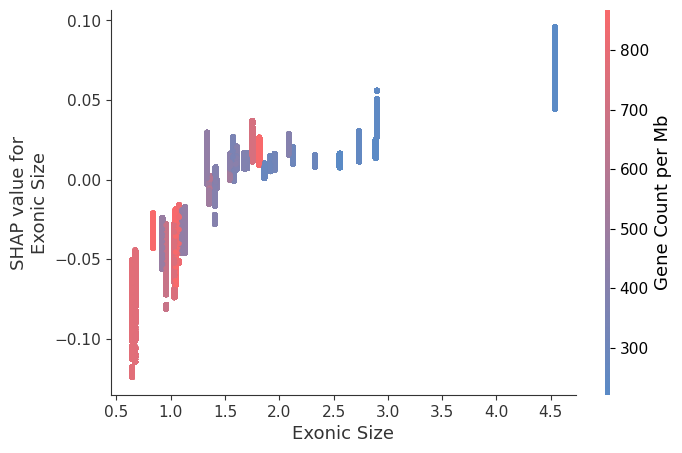

In [40]:
shap.dependence_plot("Exonic Size", r2_shap_values, r2_x_test,
                     interaction_index='Gene Count per Mb',
                     cmap = mc.LinearSegmentedColormap.from_list("",
                                                                 ['#5a8ac6',
                                                                  '#f8696b']))

In [54]:
## rmsle
rmsle_xgbt.set_param({'predictor': 'gpu_predictor'})
rmsle_dtest = DMatrix(rmsle_x_test, label=rmsle_y_test)
rmsle_pred = rmsle_xgbt.predict(rmsle_dtest, output_margin=True)
rmsle_exp = shap.TreeExplainer(rmsle_xgbt)
rmsle_shap_obj = rmsle_exp(rmsle_x_test)
rmsle_shap_interaction_values = rmsle_exp.shap_interaction_values(rmsle_x_test)
rmsle_shap_values = rmsle_shap_obj.values
np.abs(rmsle_shap_values.sum(axis=1) + rmsle_shap_obj.base_values - rmsle_pred).max()

1.66893e-06

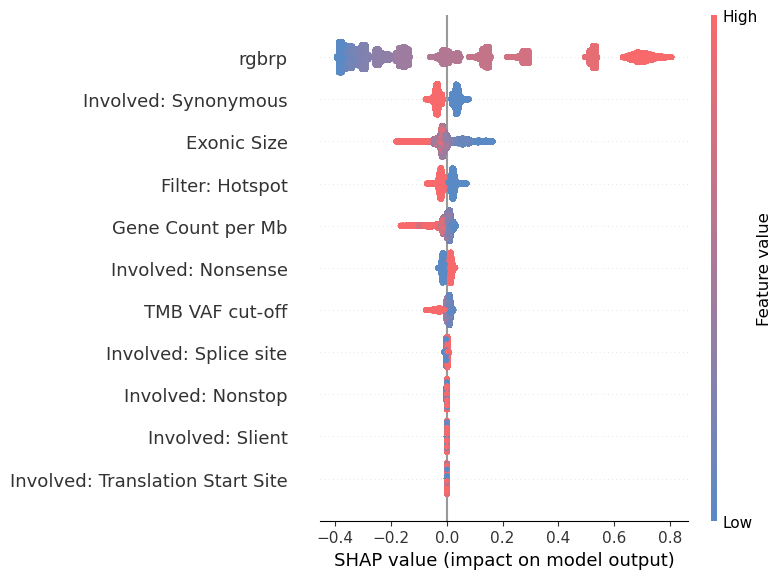

In [48]:
shap.summary_plot(rmsle_shap_values,
                  rmsle_x_test,
                  cmap = mc.LinearSegmentedColormap.from_list("",
                                                              ['#5a8ac6',
                                                               '#f8696b']))

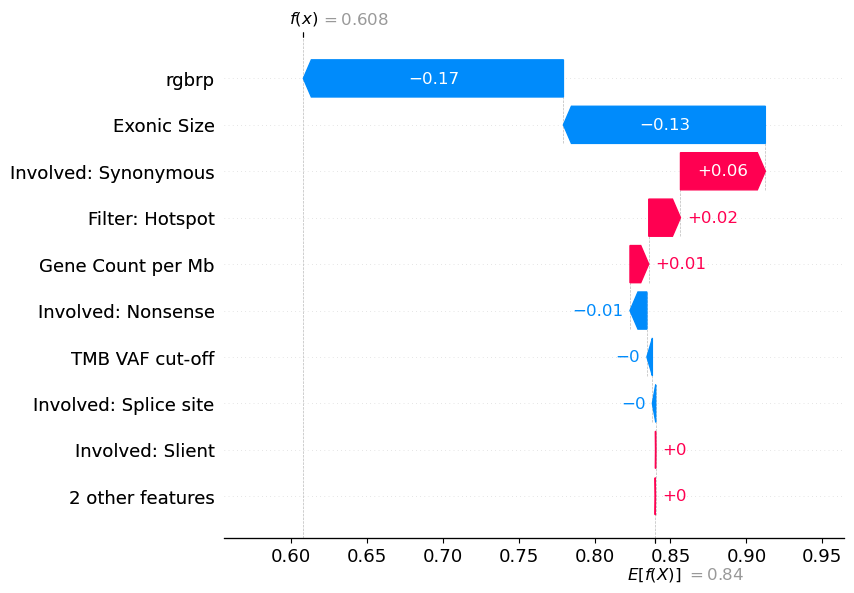

In [55]:
shap.plots._waterfall.waterfall_legacy(rmsle_exp.expected_value,
                                       rmsle_shap_values[0],
                                       feature_names=r2_x_test.columns)

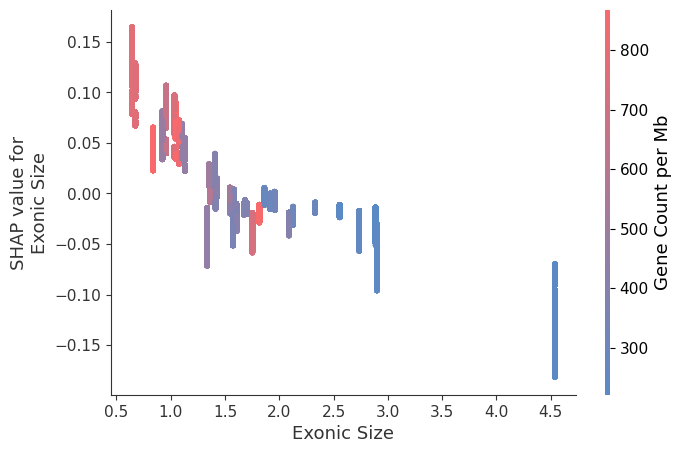

In [44]:
shap.dependence_plot("Exonic Size", rmsle_shap_values, rmsle_x_test,
                     interaction_index='Gene Count per Mb',
                     cmap = mc.LinearSegmentedColormap.from_list("",
                                                                 ['#5a8ac6',
                                                                  '#f8696b']))

In [45]:
## acc
acc_xgbt.set_param({'predictor': 'gpu_predictor'})
acc_dtest = DMatrix(acc_x_test, label=acc_y_test)
acc_pred = acc_xgbt.predict(acc_dtest, output_margin=True)
acc_exp = shap.TreeExplainer(acc_xgbt)
acc_shap_obj = acc_exp(acc_dtest)
acc_shap_interaction_values = acc_exp.shap_interaction_values(acc_x_test)
acc_shap_values = acc_shap_obj.values
np.abs(acc_shap_values.sum(axis=1) + acc_shap_obj.base_values - acc_pred).max()

2.9802322e-07

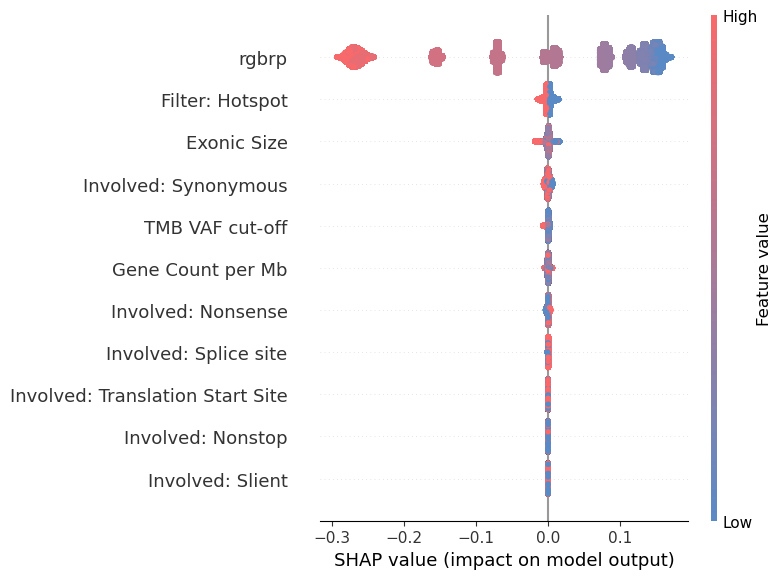

In [56]:
shap.summary_plot(acc_shap_values,
                  acc_x_test,
                  cmap = mc.LinearSegmentedColormap.from_list("",
                                                              ['#5a8ac6',
                                                               '#f8696b']))

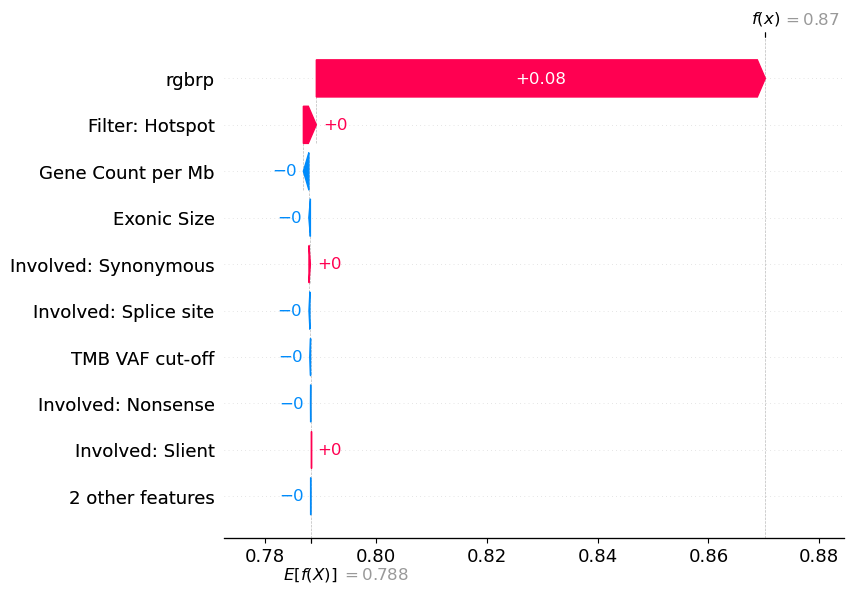

In [57]:
shap.plots._waterfall.waterfall_legacy(acc_exp.expected_value,
                                       acc_shap_values[0],
                                       feature_names=acc_x_test.columns)

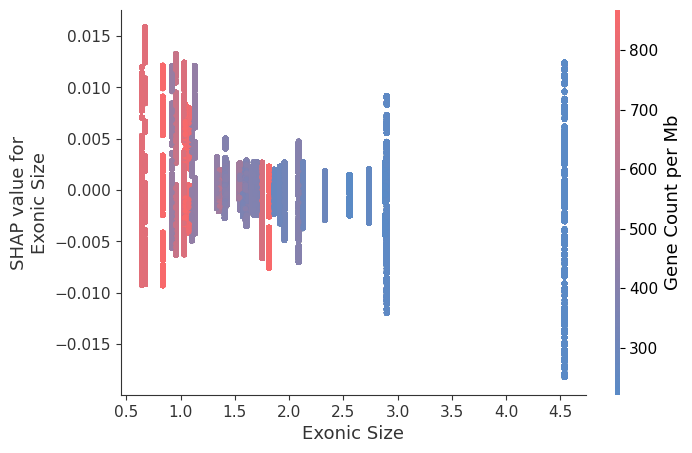

In [58]:
shap.dependence_plot("Exonic Size", acc_shap_values, acc_x_test,
                     interaction_index='Gene Count per Mb',
                     cmap = mc.LinearSegmentedColormap.from_list("",
                                                                 ['#5a8ac6',
                                                                  '#f8696b']))

In [ ]:
# save summary plots

mpl.rcParams['font.family'] = 'Calibri'  # Set font family
mpl.rcParams['font.size'] = 14  # Set font size
mpl.rcParams['axes.titleweight'] = 'bold'  # Set title weight

fig, ax = plt.subplots(figsize=(6, 4))
shap.summary_plot(r2_shap_values,
                  r2_x_test,
                  plot_size=(7, 5),
                  show = False,
                  cmap = mc.LinearSegmentedColormap.from_list("",
                                                              ['#5a8ac6',
                                                               '#f8696b']))
plt.savefig('./r2_shap.tiff', dpi=600)


fig, ax = plt.subplots(figsize=(6, 4))
shap.summary_plot(rmsle_shap_values,
                  rmsle_x_test,
                  plot_size=(7, 5),
                  show = False,
                  cmap = mc.LinearSegmentedColormap.from_list("",
                                                              ['#5a8ac6',
                                                               '#f8696b']))
plt.savefig('./rmsle_shap.tiff', dpi=600)

fig, ax = plt.subplots(figsize=(6, 4))
shap.summary_plot(acc_shap_values,
                  acc_x_test,
                  plot_size=(7, 5),
                  show = False,
                  cmap = mc.LinearSegmentedColormap.from_list("",
                                                              ['#5a8ac6',
                                                               '#f8696b']))
plt.savefig('./acc_shap.tiff', dpi=600)